# Visualizing Molecular Orbitals

This tutorial demonstrates how to plot molecular orbitals (MOs) from a closed-shell ORCA calculation using the ORCA python interface (OPI). The calculations are performed with the fast GFN2-xTB method native to ORCA. Localized orbitals are also generated and plotted. 

In this notebook we will:
1. Import the Required Dependencies.
2. Define a Working Directory. 
3. Prepare the Structure.
4. Run the ORCA Calculation.
5. Plot a Molecular Orbital Diagram.
6. Visualize the Canonical Frontier Orbitals.
7. Visualize Localized Orbitals.

## Step 1: Import Dependencies

We begin by importing all required Python modules for this tutorial. These include:

> **Note:** We import modules for visualization/plotting like `py3Dmol`. For this, it might be necessary to install `py3Dmol` into your OPI `venv` (e.g., by activating the `.venv` and using `uv pip install py3Dmol`).

In [1]:
# > Import file and directory handling
from pathlib import Path
import shutil

# > For advanced formatting in the notebook
from IPython.display import display, HTML

# > OPI imports for performing ORCA calculations and reading output
from opi.core import Calculator
from opi.input.structures.structure import Structure
from opi.input.simple_keywords import Sqm, Dft
from opi.output.core import Output

# > Import py3Dmol for 3D molecular visualization
import py3Dmol
# > Import matplotlib for plotting the MO diagram
import matplotlib.pyplot as plt

## Step 2: Define Working Directory

All actual calculations will be performed in a subfolder `RUN`.

In [2]:
# > Calculation is performed in `RUN`
working_dir = Path("RUN")
# > The `working_dir`is automatically (re-)created
shutil.rmtree(working_dir, ignore_errors=True)
working_dir.mkdir()
# > Small resolution for cube files to keep the notebook light. 
# > When you run the notebook you can choose larger values like 80 for smoother plots.
resolution = 20

## Step 3: Water Molecule for the Calculation

We define an input file in the xyz format. The molecule can be replaced by any other neutral closed-shell molecule.

In [3]:
# > Define cartesian coordinates in angstrom as python string
# > This is water 
xyz_data_water = """\
3

O      0.763468    0.595031   -0.044642
H      1.526939   -0.000000    0.000000
H      0.000000    0.000000    0.000000\n
"""

# > Alternatively, you can look for example at benzene
xyz_data_benzene = """\
12

C           -2.95158423642050        2.35836999822196        0.00212739782561
C           -4.14091557872368        1.64991032110004       -0.02391969791354
C           -1.74327014548301        1.68241626024842        0.01580886453943
H           -0.81519254019611        2.23525638004230        0.03613893725966
C           -4.12193886194957        0.26549013111527       -0.03633830745306
H           -5.08380703117622        2.17736970961569       -0.03458931904917
C           -2.91363281240151       -0.41045644578612       -0.02272181643407
H           -5.05002896510879       -0.28732892430873       -0.05668593056825
H           -2.96638917152996        3.43867643167804        0.01180502937775
C           -1.72429350123808        0.29800642953493        0.00337863588478
H           -2.89880723879466       -1.49076322175885       -0.03241213524154
H           -0.78140991697788       -0.22946706970293        0.01402834177239\n
"""

# > Select one of the structures - you can change this to benzene
xyz_data = xyz_data_water

# > Visualize the input structure
view = py3Dmol.view(width=400, height=400)
view.addModel(xyz_data, 'xyz')
view.setStyle({}, {'stick': {}, 'sphere': {'scale': 0.3}})
view.zoomTo()
view.show()

# > Write the input structure to a file
with open(working_dir / "struc.xyz","w") as f:
    f.write(xyz_data)
# > Read structure into object
structure = Structure.from_xyz(working_dir / "struc.xyz")

3Dmol.js failed to load for some reason. Please check your browser console for error messages.

## Step 4: ORCA Calculation 

We employ the semiempirical GFN2-xTB method for orbital generation to make this notebook fast. Since this is a semiempirical method, MOs can qualitatively be off from DFT calculations. So alternatively you might want to use DFT methods such as r²SCAN-3c.

In [4]:
# > Set up path for the structure
xyz_file = working_dir / "struc.xyz"

# > Create a Calculator object for ORCA input generation and execution
calc = Calculator(basename="job", working_dir=working_dir)

# > Load the molecular structure from XYZ file
structure = Structure.from_xyz(xyz_file)
calc.structure = structure

# > Add calculation keywords
calc.input.add_simple_keywords(
            Sqm.NATIVE_GFN2_XTB, # > Native GFN2-xTB
            #Dft.R2SCAN_3C       # > Alternatively DFT methods like r²SCAN-3c can be used
)

# > Request PIPEK-MEZEY localization. These will be stored in the .loc file.
calc.input.add_arbitrary_string("%loc\nLocMet PM\nend\n")

# > Write the ORCA input file
calc.write_input()
# > Run the ORCA calculation
print("Running ORCA calculation ...", end="")
calc.run()
print("   Done")

# > Get output and use it to create the gbw json output with config
output = calc.get_output()
status = output.terminated_normally()
if status: 
    output.parse()
else:
    raise RuntimeError("ORCA did not terminate normally.")

Running ORCA calculation ...   Done


## Step 5: Plot MO Diagram

We start by plotting an MO diagram. Below we define a function for plotting the MO energy levels. For larger molecules or larger basis sets this function likely has to be adjusted.

In [5]:
def plot_mo_diagram(energies, occupations, title="MO Diagram"):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title)
    ax.set_ylabel("Energy / eV")
    lumo_id = occupations.index(0)
    homo_energy = energies[lumo_id-1]
    lumo_energy = energies[lumo_id]
    
    prev_e = None
    max_x = 0
    for i, (e, occ) in enumerate(zip(energies, occupations)):
        if prev_e is not None and abs(e-prev_e) < 0.01:
            x += 2
        else:
            x = 0
        if x > max_x: max_x = x
        prev_e = e
        ax.hlines(e, x - 0.4, x + 0.4, color='k', linewidth=2)

        if occ == 2:
            ax.annotate("↑", (x, e), textcoords="offset points", xytext=(-10, -5), ha='center', fontsize=12)
            ax.annotate("↓", (x, e), textcoords="offset points", xytext=(10, -5), ha='center', fontsize=12)
        elif occ == 1:
            raise ValueError("This function does not support plotting of UHF type wavefunctions.")

        # MO index on the right, start counting at 0
        if e > homo_energy - 0.5 and e < lumo_energy + 0.5: 
            label = f"MO {i}"
            ax.text(x + 0.6, e, label, va='center', fontsize=10)

    ax.set_xlim(-1, max_x+ 1.25)
    ax.set_ylim(homo_energy - 0.5, lumo_energy + 0.5)
    ax.set_xticks([])
    ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

Now we obtain the MO data from the OPI output via the `get_mos` function and plot the MO diagramm with the function:

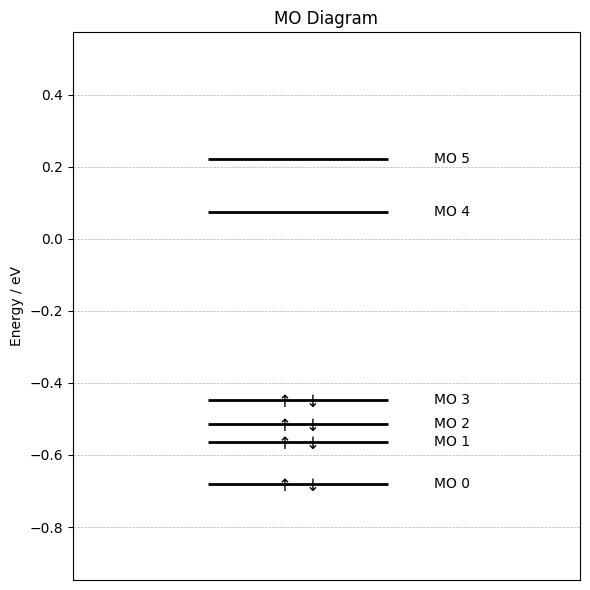

In [6]:
mo_list = output.get_mos()["mo"]
energies = [mo.orbitalenergy for mo in mo_list]
occupations = [mo.occupancy for mo in mo_list]   
plot_mo_diagram(energies, occupations) 

## Step 6: Visualize Frontier MOs

We define a function for depicting the molecular orbitals. The cube output object is obtained from the `plot_mos` function and read by accessing the `cube` property. The following orbitals are plotted: HOMO-2, HOMO-1, and HOMO.

In [7]:
def visualize_mos(output: Output, plot_list: list[int], resolution: int, gbw_type: str):
    """Visualize a list of mo indices"""
    # > For nicely visualizing multiple MOs in this notebook we wrap
    # > py3Dmol viewers in html
    html_blocks = []

    for mo_index in plot_list:
        # > Obtain cube data of MO
        cube_output = output.plot_mo(mo_index, resolution=resolution, gbw_type=gbw_type)
        cube_data = cube_output.cube

        # Set up Py3Dmol viewer for cube data
        view = py3Dmol.view(width=250, height=250)
        view.addModel(xyz_data, "xyz")
        view.setStyle({'stick': {'radius': 0.1}, 'sphere': {'scale': 0.2}})
        view.addVolumetricData(cube_data, "cube", {"isoval": 0.005, "color": "blue", "opacity": 0.8})
        view.addVolumetricData(cube_data, "cube", {"isoval": -0.005, "color": "red", "opacity": 0.8})
        view.zoomTo()

        # > HTML formatting
        viewer_html = view._make_html()
        html = f"""
        <div style="display:inline-block; text-align:center; margin-right:10px;">
            <div><b>MO {mo_index}</b></div>
            {viewer_html}
        </div>
        """
        html_blocks.append(html)

    # Display all viewers with labels
    display(HTML(''.join(html_blocks)))

# > Plot orbitals 
nel, _ = output.get_nelectrons()
homo_index = nel // 2 - 1
plot_list = [homo_index-2,homo_index-1,homo_index]
visualize_mos(output=output, plot_list=plot_list, resolution=resolution, gbw_type="gbw")

The canonical orbitals are delocalized. MO 3 is the highest occupied orbital (HOMO) and represents a lone pair of $\pi$-symmetry.

## Step 7: Visualize Localized Orbitals

Now we visualize the localized orbitals from the PM localization scheme:

In [8]:
visualize_mos(output=output, plot_list=plot_list, resolution=resolution, gbw_type="loc")

The localized MOs (LMOs) are linear combination of the three canonical orbitals shown in the section before. MO 2 and MO 3 can be viewed as representations of the two O-H bonds in the Lewis structure with $\sigma$-symmetry, while MO 1 represents a lone pair of $\sigma$-symmetry. 

## Summary

In this notebook we demonstrated how to obtain cube data for molecular orbitals from OPI and how to plot the results using `py3Dmol`. The notebook can be downloaded and run locally. The molecule can be replaced with any other neutral closed-shell molecule (adjustments migh have to be made to the MO diagram plot function). Also, the level of theory can be adjusted to any SCF method natively implemented in ORCA.  